In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Bayesian Bandits

Bayesian Bandits with beta-binomial models are a fun flavor of multi-armed bandit problems that use thompson sampling to do a pretty simple implementation of reinforcement learning.

In this notebook we'll start off with a grid of locations. At each location we have a certain fixed unknown probability of having a good time! Each turn we'll visit some subset of these locations, see if we had a good time or a bad time, and based on that we'll update our beliefs about if that spot is a fun location or a not fun location. 

We'll see how our process begins with exploration--determining which spots are good--but eventually converts to exploitation--where we consistently visit the better spots.

### True Probability of Having a Good Time

We'll set it so most of the locations you either like quite a bit or don't like very much at all. If you *always* enjoy a spot, it gets a value of 1.0. If you *never* like a spot, it gets a value of 0.0. We'll use a beta distribution to generate the true values over our grid, and bias us towards not liking a place over liking it. Note that in this case, each spot does have a single fixed true probability of having a good time there!

In [119]:
np.random.seed(42)
array_size = [10,10]
true_p = np.round(np.random.beta(0.2,0.4,array_size), 2)

(array([44.,  6.,  6.,  5.,  3.,  6.,  5.,  3.,  6., 16.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

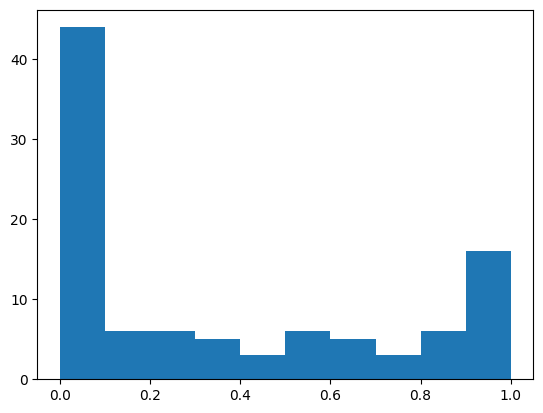

In [120]:
plt.hist(true_p.flatten())

In [122]:
true_p

array([[0.01, 0.43, 0.01, 0.  , 0.16, 0.  , 0.95, 0.01, 0.01, 0.25],
       [0.92, 0.03, 0.03, 0.  , 0.99, 0.87, 0.  , 0.47, 0.54, 0.  ],
       [0.  , 0.  , 0.01, 0.77, 0.09, 0.  , 0.  , 0.19, 0.84, 0.01],
       [0.  , 0.  , 0.94, 0.  , 0.28, 0.99, 0.56, 0.61, 0.8 , 0.05],
       [0.39, 0.78, 0.  , 0.52, 0.61, 0.25, 0.  , 0.  , 0.02, 0.95],
       [0.02, 0.28, 0.16, 0.13, 0.96, 0.73, 0.45, 0.01, 0.  , 0.35],
       [0.  , 0.93, 0.08, 0.01, 0.96, 0.38, 0.88, 0.32, 0.  , 0.96],
       [0.  , 0.97, 0.21, 0.  , 0.02, 0.33, 0.  , 0.18, 0.  , 1.  ],
       [0.59, 0.9 , 0.63, 0.99, 0.52, 0.  , 0.61, 0.59, 0.  , 0.65],
       [0.06, 0.21, 0.98, 0.  , 1.  , 0.  , 0.  , 0.11, 0.83, 0.87]])

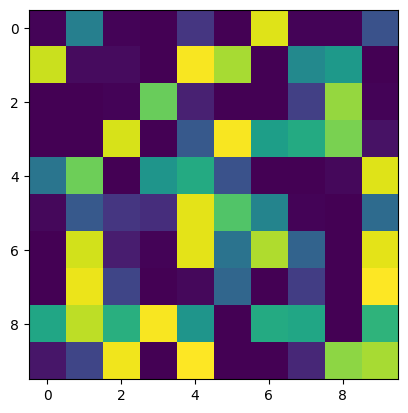

In [121]:
plt.imshow(true_p, cmap='viridis')

### Running The Machine



In [141]:
class Banditry:

    def __init__(self, reality):
        np.random.seed(42)
        self.true_p = reality
        self.grid_shape = self.true_p.shape
        self.initialize_beliefs()
        self.track_visits = []
    def initialize_beliefs(self):
        """
        our belief about a certain location is held in a beta distribution with two parameters
        we'll store those two parameters in a numpy array where alpha is indexed at 0 and beta is indexed at 1
        """
        self.happiness_beliefs = np.zeros((self.grid_shape[0], self.grid_shape[1], 2))
        # we'll set a weak prior of alpha=1, beta=1 everywhere
        self.happiness_beliefs += 1

    def play_one_round(self):
        # to get our beliefs about where we should go we sample from beta distributions using the current params for alpha and beta at each idx
        anticipated_outcomes = np.random.beta(self.happiness_beliefs[:,:,0], self.happiness_beliefs[:,:,1])
        visit_raveled_idx = np.argmax(anticipated_outcomes)
        visit_unraveled_idx = np.unravel_index(visit_raveled_idx, self.grid_shape)
        self.track_visits.append(visit_unraveled_idx)
        # visit the location, get the real probability, and generate an outcome from it
        p = self.true_p[visit_unraveled_idx]
        outcome = np.random.binomial(1, p)

        # bayesian updating our beliefs is very simple for beta binomial! heads, add 1 to alpha. tails, add 1 to beta. nice!
        # if "heads" then update alpha -> alpha + 1
        if outcome == 1:
            self.happiness_beliefs[visit_unraveled_idx[0], visit_unraveled_idx[1], 0] += 1
        # otherwise, beta gets bumped up
        elif outcome==0:
            self.happiness_beliefs[visit_unraveled_idx[0], visit_unraveled_idx[1], 1] += 1

    def play_k_rounds(self, k):
        for i in range(k):
            self.play_one_round()

    def get_posterior_mean_beliefs(self):
        self.posterior_beliefs = self.happiness_beliefs[:,:,0] / (self.happiness_beliefs[:,:,0] + self.happiness_beliefs[:,:,1])


In [159]:
bd = Banditry(true_p)

In [160]:
bd.get_posterior_mean_beliefs()
bd.posterior_beliefs

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [161]:
bd.play_k_rounds(10)
bd.get_posterior_mean_beliefs()
np.round(bd.posterior_beliefs, 2)

array([[0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
       [0.67, 0.33, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
       [0.5 , 0.5 , 0.33, 0.5 , 0.5 , 0.33, 0.5 , 0.5 , 0.5 , 0.5 ],
       [0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
       [0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.33, 0.5 , 0.5 , 0.5 ],
       [0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.33, 0.33, 0.5 ],
       [0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.67],
       [0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.33, 0.5 , 0.5 , 0.5 ],
       [0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
       [0.33, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ]])

In [162]:
bd.true_p

array([[0.01, 0.43, 0.01, 0.  , 0.16, 0.  , 0.95, 0.01, 0.01, 0.25],
       [0.92, 0.03, 0.03, 0.  , 0.99, 0.87, 0.  , 0.47, 0.54, 0.  ],
       [0.  , 0.  , 0.01, 0.77, 0.09, 0.  , 0.  , 0.19, 0.84, 0.01],
       [0.  , 0.  , 0.94, 0.  , 0.28, 0.99, 0.56, 0.61, 0.8 , 0.05],
       [0.39, 0.78, 0.  , 0.52, 0.61, 0.25, 0.  , 0.  , 0.02, 0.95],
       [0.02, 0.28, 0.16, 0.13, 0.96, 0.73, 0.45, 0.01, 0.  , 0.35],
       [0.  , 0.93, 0.08, 0.01, 0.96, 0.38, 0.88, 0.32, 0.  , 0.96],
       [0.  , 0.97, 0.21, 0.  , 0.02, 0.33, 0.  , 0.18, 0.  , 1.  ],
       [0.59, 0.9 , 0.63, 0.99, 0.52, 0.  , 0.61, 0.59, 0.  , 0.65],
       [0.06, 0.21, 0.98, 0.  , 1.  , 0.  , 0.  , 0.11, 0.83, 0.87]])

In [163]:
bd.play_k_rounds(100)
bd.get_posterior_mean_beliefs()
np.round(bd.posterior_beliefs, 2)

array([[0.33, 0.6 , 0.33, 0.33, 0.67, 0.33, 0.5 , 0.5 , 0.33, 0.33],
       [0.9 , 0.33, 0.5 , 0.33, 0.83, 0.5 , 0.33, 0.5 , 0.5 , 0.33],
       [0.5 , 0.33, 0.33, 0.33, 0.33, 0.33, 0.5 , 0.5 , 0.5 , 0.33],
       [0.33, 0.5 , 0.67, 0.33, 0.33, 0.86, 0.33, 0.71, 0.5 , 0.33],
       [0.5 , 0.5 , 0.33, 0.5 , 0.5 , 0.33, 0.33, 0.33, 0.33, 0.6 ],
       [0.33, 0.33, 0.33, 0.5 , 0.67, 0.5 , 0.75, 0.33, 0.33, 0.5 ],
       [0.33, 0.67, 0.5 , 0.5 , 0.5 , 0.33, 0.83, 0.33, 0.5 , 0.88],
       [0.5 , 0.67, 0.5 , 0.5 , 0.5 , 0.5 , 0.33, 0.33, 0.5 , 0.5 ],
       [0.75, 0.5 , 0.5 , 0.9 , 0.5 , 0.33, 0.5 , 0.5 , 0.33, 0.5 ],
       [0.33, 0.33, 0.75, 0.33, 0.5 , 0.33, 0.5 , 0.5 , 0.67, 0.5 ]])

In [164]:
bd.true_p

array([[0.01, 0.43, 0.01, 0.  , 0.16, 0.  , 0.95, 0.01, 0.01, 0.25],
       [0.92, 0.03, 0.03, 0.  , 0.99, 0.87, 0.  , 0.47, 0.54, 0.  ],
       [0.  , 0.  , 0.01, 0.77, 0.09, 0.  , 0.  , 0.19, 0.84, 0.01],
       [0.  , 0.  , 0.94, 0.  , 0.28, 0.99, 0.56, 0.61, 0.8 , 0.05],
       [0.39, 0.78, 0.  , 0.52, 0.61, 0.25, 0.  , 0.  , 0.02, 0.95],
       [0.02, 0.28, 0.16, 0.13, 0.96, 0.73, 0.45, 0.01, 0.  , 0.35],
       [0.  , 0.93, 0.08, 0.01, 0.96, 0.38, 0.88, 0.32, 0.  , 0.96],
       [0.  , 0.97, 0.21, 0.  , 0.02, 0.33, 0.  , 0.18, 0.  , 1.  ],
       [0.59, 0.9 , 0.63, 0.99, 0.52, 0.  , 0.61, 0.59, 0.  , 0.65],
       [0.06, 0.21, 0.98, 0.  , 1.  , 0.  , 0.  , 0.11, 0.83, 0.87]])

In [165]:
bd.play_k_rounds(10000)
bd.get_posterior_mean_beliefs()
np.round(bd.posterior_beliefs, 2)

array([[0.33, 0.6 , 0.33, 0.33, 0.5 , 0.33, 0.6 , 0.33, 0.33, 0.33],
       [0.88, 0.33, 0.25, 0.25, 0.97, 0.89, 0.33, 0.33, 0.5 , 0.33],
       [0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.5 , 0.33],
       [0.33, 0.33, 0.8 , 0.33, 0.33, 0.94, 0.33, 0.67, 0.71, 0.33],
       [0.5 , 0.33, 0.33, 0.33, 0.5 , 0.33, 0.33, 0.33, 0.33, 0.6 ],
       [0.33, 0.33, 0.33, 0.5 , 0.91, 0.5 , 0.6 , 0.33, 0.25, 0.33],
       [0.33, 0.94, 0.33, 0.33, 0.93, 0.33, 0.79, 0.33, 0.5 , 0.86],
       [0.33, 0.83, 0.33, 0.33, 0.33, 0.5 , 0.33, 0.33, 0.33, 1.  ],
       [0.6 , 0.82, 0.6 , 0.99, 0.5 , 0.33, 0.5 , 0.5 , 0.33, 0.5 ],
       [0.33, 0.33, 0.99, 0.33, 1.  , 0.33, 0.33, 0.33, 0.71, 0.5 ]])

In [166]:
bd.track_visits[-10:-1] 

[(7, 9), (7, 9), (7, 9), (9, 4), (7, 9), (7, 9), (9, 4), (9, 4), (7, 9)]

### Results

We can see here that the algorithm has converged to a certain idea of the space that isn't quite accurate! For example, (7, 2) is set to a 97% satisfaction rate, but we estimate it at 83%. Instead we've gotten sucked into a few coordinates that we've determined with very high precision are great spots to be--(7,9) and (9,4) to be precise. In part this is happening because they do have absurdly high real happiness rates--why go anywhere else in that case and keep exploring? If their true happiness rates were lower, the algorithm would have them sometimes losing the draw and we'd continue exploring more. 

Overall, very cool to see how the beliefs evolve. They evolve only to the extent that our optimization requires learning more about the enviornment--versus just exploiting! :)

### Dynamic True Probabilities

A fun extension of this would be to have the true probabilities of having fun vary according to something like time or even my own state. If it's just time-varying, what's interesting about the bandit algorithm is you can just run it--if a spot that used to provide high reward stops doing so, the bandit does incorporate that and updates accordingly, eventually moving away from that spot. However, there's a memory issue, in the sense that happy times from long ago count just as much as a happy time from today--so if the variation in underlying params is slow our response time will also be slow. But in theory it would work!

In practice, you'd want to move out of the beta-binomial model and towards a more complicated bandit. One way you could do this is to apply a deterministic function to the counts going into the model--for example, downweighting older counts as a function of age. Then you can still preserve the beta-binomial (and its incredible ease of computation). But for more complex stuff you might have to move off the beta-binomial and use stronger bayesian software to help you with the numerical heavy lifting.